In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns
import tikzplotlib as tikz

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess as pre
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [2]:
# path = '/home/leonriccius/Desktop/CurvedBackwardFacingStep/Re13700_kOmega_150_ml'
# rans_time = max([int(entry) for entry in os.listdir(path) if entry.isnumeric()])
# print(rans_time)

# grid_rans = pre.readCellCenters(rans_time, path)
# u_rans = pre.readVectorData(rans_time, 'U', path)
# u_levm = pre.readVectorData('3000', 'U', path)

# path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata/CurvedBackwardFacingStep/13700'
# grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))
# u_dns = th.load(os.sep.join([path_dns, 'u_dns-torch.th']))

In [3]:
# read in rans solution from b_ml
path = '/home/leonriccius/Desktop/PeriodicHills/Re2800_kOmega_150_dd_reg/'
rans_time = max([int(entry) for entry in os.listdir(path) if entry.isnumeric()])
grid_rans = pre.readCellCenters(rans_time, path)
u_rans = pre.readVectorData(rans_time, 'U', path)
u_levm = pre.readVectorData('30000', 'U', path)

# read in rans solution from b_dns
path_rans_bdns = '/home/leonriccius/Desktop/PeriodicHills/Re2800_kOmega_150_dns/'
rans_time = max([int(entry) for entry in os.listdir(path_rans_bdns) if entry.isnumeric()])
u_rans_dns = pre.readVectorData(rans_time, 'U', path_rans_bdns)

# read in dns solution
path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata/PeriodicHills/2800'
grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))
u_dns = th.load(os.sep.join([path_dns, 'u_dns-torch.th']))

Reading mesh cell centers /home/leonriccius/Desktop/PeriodicHills/Re2800_kOmega_150_dd_reg//35000/cellCenters
Attempting to read file: /home/leonriccius/Desktop/PeriodicHills/Re2800_kOmega_150_dd_reg//35000/U
Parsing file...
Data field file successfully read.
Attempting to read file: /home/leonriccius/Desktop/PeriodicHills/Re2800_kOmega_150_dd_reg//30000/U
Parsing file...
Data field file successfully read.
Attempting to read file: /home/leonriccius/Desktop/PeriodicHills/Re2800_kOmega_150_dns//31000/U
Parsing file...
Data field file successfully read.


0.03214286 8.967857
0.0543214314617213 8.945357360839843


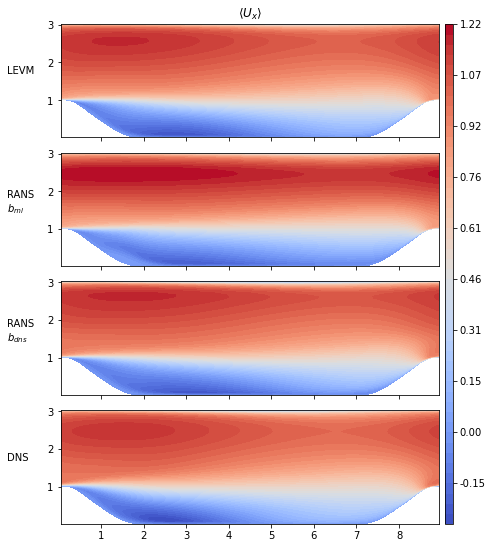

In [4]:
nrows = 4
ncols = 1
s = 1.5

idx = [0]

ref = 20
gamma = 0.995
x_min, x_max = np.min(grid_rans[:,0].numpy()), np.max(grid_rans[:,0].numpy())
x_mean = 0.5*(x_max - x_min)
x_min_neu = x_mean - gamma*(x_mean - x_min)
x_max_neu = x_mean - gamma*(x_mean - x_max)

y_min, y_max = np.min(grid_rans[:,1].numpy()), np.max(grid_rans[:,1].numpy())
y_mean = 0.5*(y_max - y_min)
y_min_neu = y_mean - gamma*(y_mean - y_min)
y_max_neu = y_mean - gamma*(y_mean - y_max)

print(x_min, x_max)
print(x_min_neu, x_max_neu)
x_min, x_max = x_min_neu, x_max_neu
y_min, y_max = y_min_neu, y_max_neu

nx = int(ref*(x_max - x_min))
ny = int(ref*(y_max - y_min))

grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
grid_y = ph_interp(grid_x)*(y_max - grid_y)/y_max + grid_y

grid_u_rans = griddata(grid_rans[:,0:2], u_rans.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_levm = griddata(grid_rans[:,0:2], u_levm.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_rans_dns = griddata(grid_dns[:,0:2], u_rans_dns.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_dns = griddata(grid_dns[:,0:2], u_dns.detach().numpy(), (grid_x, grid_y), method = 'linear') #, fill_value=0.)

# get min an max of (b_pred, b_test) for colormap
tmp = th.cat((u_rans[:,idx[0]], u_dns[:,idx[0]])).detach().numpy()
b_min = np.min(tmp)
b_max = np.max(tmp)
levels = np.linspace(b_min, b_max, 50)

# # create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.5*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)

cmap = matplotlib.cm.get_cmap("coolwarm")
# cmap.set_over([0.70567315799999997, 0.015556159999999999, 0.15023281199999999, 1.0])
# cmap.set_under([0.2298057, 0.298717966, 0.75368315299999999, 1.0])

levm_plot = ax[0].contourf(grid_x, grid_y, grid_u_levm[:,:,idx[0]], levels = levels, cmap=cmap)
rans_plot = ax[1].contourf(grid_x, grid_y, grid_u_rans[:,:,idx[0]], levels = levels, cmap=cmap)
rans_dns_plot = ax[2].contourf(grid_x, grid_y, grid_u_rans_dns[:,:,idx[0]], levels = levels, cmap=cmap)
dns_plot = ax[3].contourf(grid_x, grid_y, grid_u_dns[:,:,idx[0]], levels = levels, cmap=cmap)

# fig.colorbar(b_dd_plot, ax=ax.flat, aspect=15*ncols*nrows, format='%.2f', pad=0.0)
fig.colorbar(rans_plot, ax=ax.flat, aspect=15*ncols*nrows, format='%.2f', pad=0.0)
# fig.colorbar(b_dns_plot, ax=ax[1], aspect=15*ncols*nrows, format='%.2f', pad=0.0)

x_off = -1.2
y_off = 1.7

ax[0].set_title(r'$\langle U_x \rangle$')

ax[0].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left')
ax[1].text(x_off,y_off, r'RANS' '\n' r'$b_{ml}$', fontsize='medium', ha='left', va='center')
ax[2].text(x_off,y_off, r'RANS' '\n' r'$b_{dns}$', fontsize='medium', ha='left', va='center')
ax[3].text(x_off,y_off, r'DNS', fontsize='medium', ha='left')


# save fig
fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN'
fig_name =  time() + '_phill_2800_forward_U_x.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

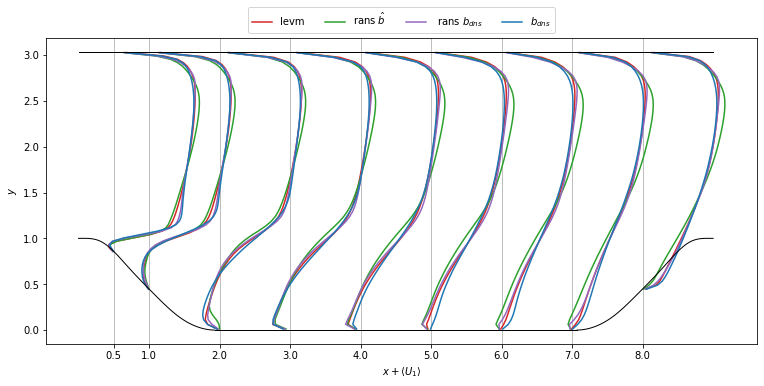

In [7]:
# set path to save figures
# fig_path = '/home/leonriccius/Desktop'

# select x locations to plot
x_data = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
tol = 4e-2

# select components
components = [0]

# set number of columns to plot
ncols = 1
nrows = len(components)

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5*7*ncols, 1.5*3.5*nrows),
                        sharex=True, sharey=True, constrained_layout=True)
plt.xticks(x_data)

for i, cmp in enumerate(components):
    for j, val in enumerate(x_data):
        # find x location in grid
        x_loc = np.argmin(np.absolute(grid_x[0] - val))
        x_val = grid_x[0, x_loc]

        # create mask and select points in the slice
        grid_slice = grid_y[:, x_loc]
        u_dns_slice = grid_u_dns[:, x_loc, cmp]
        u_levm_slice = grid_u_levm[:, x_loc, cmp]
        u_rans_slice = grid_u_rans[:, x_loc, cmp]
        u_rans_dns_slice = grid_u_rans_dns[:, x_loc, cmp]

        # plot all bs for current slice
        axs.plot(u_levm_slice + val, grid_slice,
                   color=sns.color_palette()[3]) #, label = r'$b_{levm}')
        axs.plot(u_rans_slice + val, grid_slice,
                   color=sns.color_palette()[2]) #, label = r'$rans \hat b$')
        axs.plot(u_rans_dns_slice + val, grid_slice,
                   color=sns.color_palette()[4]) #, label = r'$b_{dns}$')
        axs.plot(u_dns_slice + val, grid_slice,
                   color=sns.color_palette()[0]) #, label = r'$b_{dns}$')
        axs.set_ylabel(r'$y$')
    
    # plot lower and upper wall of hill and grid
    barymap.plot_periodic_hills_boundaries(axs)
    axs.grid(axis='x')

# plot legend    
axs.legend([r'levm', r'rans $\hat b$', r' rans $b_{dns}$', r'$b_{dns}$'], bbox_to_anchor=(0.5, 1.00), loc='lower center', ncol=4)

# plot xlabel
axs.set_xlabel(r'$x + \langle U_1 \rangle$')

# save figure
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_the'
fig_name = 'phill_2800_b_on_slices.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')